In [28]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import KFold, train_test_split
from torch.optim.lr_scheduler import StepLR
import optuna
import warnings
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def data_segmentation(df, y_label, window_size = 100, stride = 50):
    '''
    Segments the data into the same length and detach the whole dataset into X and y.
    
    df: data frame that contains all covariates and response variables
    y_label: the column name of the response variable that we want to predict
    window_size: the length of time included in a single data point
    stride: The interval between two closest segmented data point
    '''
    j = df.columns.get_loc(y_label)
    data = df.to_numpy()
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    
    while start <= n - window_size:
        end = start + window_size - 1
        if data[start][j] == data[end][j] and data[start][0] + 0.01 > data[end][0] and data[start][j]!=0:
            X.append(data[start:(end+1),1:-7])
            y.append(data[start][j])
            start += stride
        else:
            while start + window_size - 1 < n:
                if data[start][j] != data[start+1][j]:
                    break
                start += 1
            start += 1
    return np.asarray(X), np.asarray(y)

In [3]:
def count_parameters(model):
    """Returns the total number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def train_model(model, data_loader, criterion, optimizer, num_epochs, scheduler=None, print_every_n_batches=100):
    """
    Trains the model and prints the parameter count and running loss periodically.
    Accepts an optional scheduler.
    """

    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every_n_batches == 0:
                avg_loss = running_loss / print_every_n_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i+1}/{len(data_loader)}] | Running Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
                running_loss = 0.0
        if scheduler is not None:
            scheduler.step()

    print("\nFinished Training.")
    return model
def test_model(model, test_loader):
    """
    Tests the trained model and prints the parameter count and final accuracy.
    """
    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.eval()
    model.to(device)
    correct = 0
    total = 0
    y_test = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_test = np.append(y_test, labels.cpu().numpy())
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)


        # Print the evaluation metrics
        print("Accuracy:", f"{accuracy:.4f}")
        print("Precision:", f"{precision:.4f}")
        print("Recall:", f"{recall:.4f}")
        print("F1 Score:", f"{f1:.4f}")
        print(f"\nTest accuracy of model: {accuracy*100:.2f}%")
        cm = confusion_matrix(y_test, y_pred)

        # plot the confusion matrix
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
        plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    return accuracy

In [22]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, cnn_channels, hidden_size, 
                 num_layers, output_size, dropout_rate):
        super(CNNLSTM, self).__init__()
        
        self.input_size = input_size
        self.cnn_channels = cnn_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_size, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(256, cnn_channels, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2), 
            nn.Dropout(dropout_rate)
        )

        self.lstm = nn.LSTM(cnn_channels, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x_lstm = x.permute(0, 2, 1)
        lstm_out, (h_n, c_n) = self.lstm(x_lstm)
        final_hidden_state = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)
        output = self.fc(final_hidden_state)
        
        return output


In [5]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
X_train, y_train = data_segmentation(df_train, "HL_Activity")
X_test, y_test = data_segmentation(df_test, "HL_Activity")  
y_train -= 101
y_test -= 101


Model Architecture:
CNNLSTM(
  (conv1): Sequential(
    (0): Conv1d(242, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=3

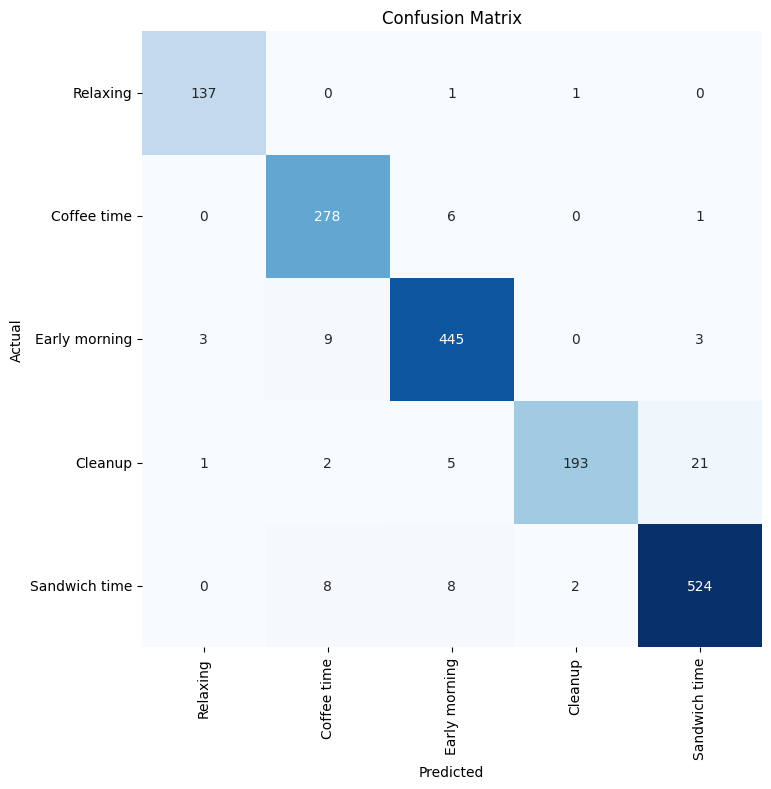

In [23]:
input_size = X_train.shape[2]
sequence_length = 100
cnn_channels = 512
hidden_size = 256
num_layers = 2
output_size = 5
# Training Hyperparameters
batch_size = 32
num_epochs = 5
learning_rate = 0.0001
dropout_rate = 0.2
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_size = int(0.8*len(train_dataset))
val_size = int(len(train_dataset)) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(train_dataset
    , batch_size=batch_size,
    shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4
)
testloader = torch.utils.data.DataLoader(test_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4)

model = CNNLSTM(input_size, cnn_channels, hidden_size, 
                num_layers, output_size, dropout_rate).to(device)

# Using Mean Squared Error loss for a regression problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
print("\nModel Architecture:")
print(model)
train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs, scheduler=scheduler)
acc = test_model(model, valloader)

In [24]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
def objective(trial):
    cnn_channels = trial.suggest_categorical('cnn_channels', [64, 128, 256])
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    num_layers = trial.suggest_int('num_layers', 1, 2) # LSTM layers
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    model = CNNLSTM(
        input_size=input_size,
        cnn_channels=cnn_channels,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=output_size,
        dropout_rate=dropout_rate
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # --- C. Training Loop ---
    for epoch in range(num_epochs):
        model.train()
        for data, targets in trainloader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
    # --- D. Validation Loop (Evaluate) ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in valloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    val_accuracy = correct / total
    return val_accuracy

print("--- Starting Hyperparameter Tuning (Step 1) ---")
# Create a study. "maximize" means Optuna will try to get the highest accuracy.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Run 20 different models

# --- Get the best parameters ---
best_params = study.best_params
print(f"\nHPT Complete. Best parameters found:\n{best_params}\n")

--- Starting Hyperparameter Tuning (Step 1) ---

HPT Complete. Best parameters found:
{'cnn_channels': 64, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.21985699601697986, 'lr': 8.863348802631267e-05}




Number of model parameters is: 1122373
Epoch [1/5] | Batch [100/258] | Running Loss: 1.1505 | LR: 0.000089
Epoch [1/5] | Batch [200/258] | Running Loss: 0.7748 | LR: 0.000089
Epoch [2/5] | Batch [100/258] | Running Loss: 0.5744 | LR: 0.000089
Epoch [2/5] | Batch [200/258] | Running Loss: 0.4959 | LR: 0.000089
Epoch [3/5] | Batch [100/258] | Running Loss: 0.3908 | LR: 0.000089
Epoch [3/5] | Batch [200/258] | Running Loss: 0.3623 | LR: 0.000089
Epoch [4/5] | Batch [100/258] | Running Loss: 0.2921 | LR: 0.000089
Epoch [4/5] | Batch [200/258] | Running Loss: 0.2664 | LR: 0.000089
Epoch [5/5] | Batch [100/258] | Running Loss: 0.2175 | LR: 0.000089
Epoch [5/5] | Batch [200/258] | Running Loss: 0.2123 | LR: 0.000089

Finished Training.

Number of model parameters is: 1122373
Accuracy: 0.6138
Precision: 0.6183
Recall: 0.6138
F1 Score: 0.5748

Test accuracy of model: 61.38%


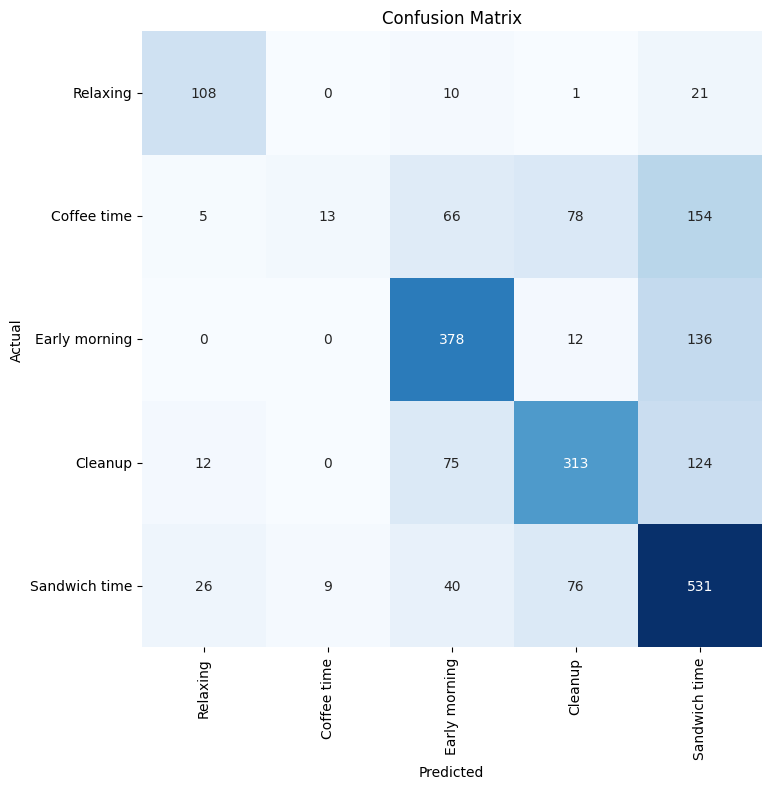


Number of model parameters is: 1122373
Epoch [1/5] | Batch [100/258] | Running Loss: 1.1271 | LR: 0.000089
Epoch [1/5] | Batch [200/258] | Running Loss: 0.7838 | LR: 0.000089
Epoch [2/5] | Batch [100/258] | Running Loss: 0.5794 | LR: 0.000089
Epoch [2/5] | Batch [200/258] | Running Loss: 0.4988 | LR: 0.000089
Epoch [3/5] | Batch [100/258] | Running Loss: 0.3889 | LR: 0.000089
Epoch [3/5] | Batch [200/258] | Running Loss: 0.3679 | LR: 0.000089
Epoch [4/5] | Batch [100/258] | Running Loss: 0.2923 | LR: 0.000089
Epoch [4/5] | Batch [200/258] | Running Loss: 0.2782 | LR: 0.000089
Epoch [5/5] | Batch [100/258] | Running Loss: 0.2285 | LR: 0.000089
Epoch [5/5] | Batch [200/258] | Running Loss: 0.2104 | LR: 0.000089

Finished Training.

Number of model parameters is: 1122373
Accuracy: 0.6024
Precision: 0.6765
Recall: 0.6024
F1 Score: 0.5675

Test accuracy of model: 60.24%


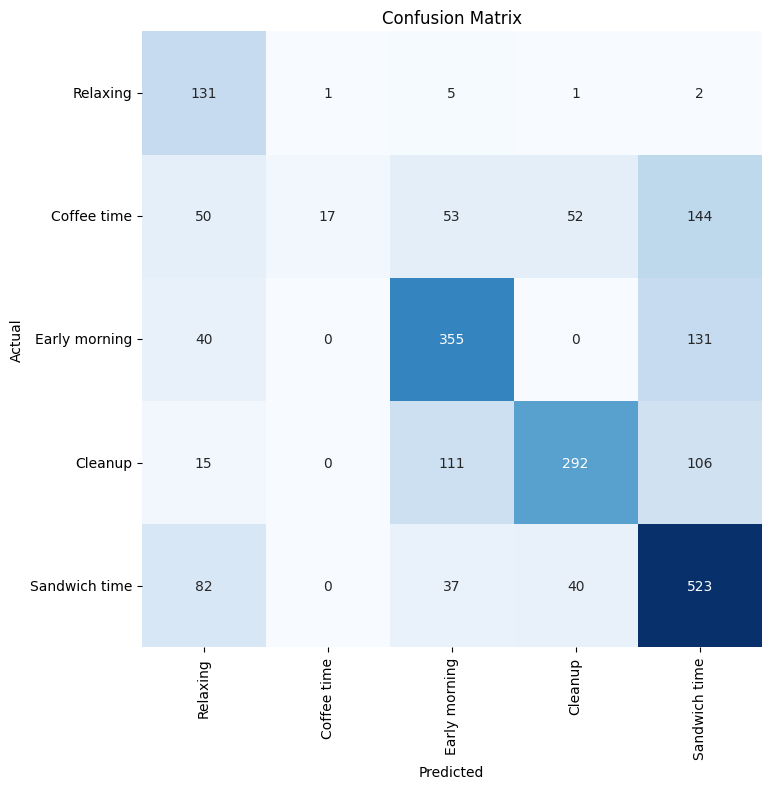


Number of model parameters is: 1122373
Epoch [1/5] | Batch [100/258] | Running Loss: 1.1479 | LR: 0.000089
Epoch [1/5] | Batch [200/258] | Running Loss: 0.7879 | LR: 0.000089
Epoch [2/5] | Batch [100/258] | Running Loss: 0.5773 | LR: 0.000089
Epoch [2/5] | Batch [200/258] | Running Loss: 0.5189 | LR: 0.000089
Epoch [3/5] | Batch [100/258] | Running Loss: 0.3952 | LR: 0.000089
Epoch [3/5] | Batch [200/258] | Running Loss: 0.3635 | LR: 0.000089
Epoch [4/5] | Batch [100/258] | Running Loss: 0.2899 | LR: 0.000089
Epoch [4/5] | Batch [200/258] | Running Loss: 0.2766 | LR: 0.000089
Epoch [5/5] | Batch [100/258] | Running Loss: 0.2269 | LR: 0.000089
Epoch [5/5] | Batch [200/258] | Running Loss: 0.2202 | LR: 0.000089

Finished Training.

Number of model parameters is: 1122373
Accuracy: 0.6056
Precision: 0.6142
Recall: 0.6056
F1 Score: 0.5843

Test accuracy of model: 60.56%


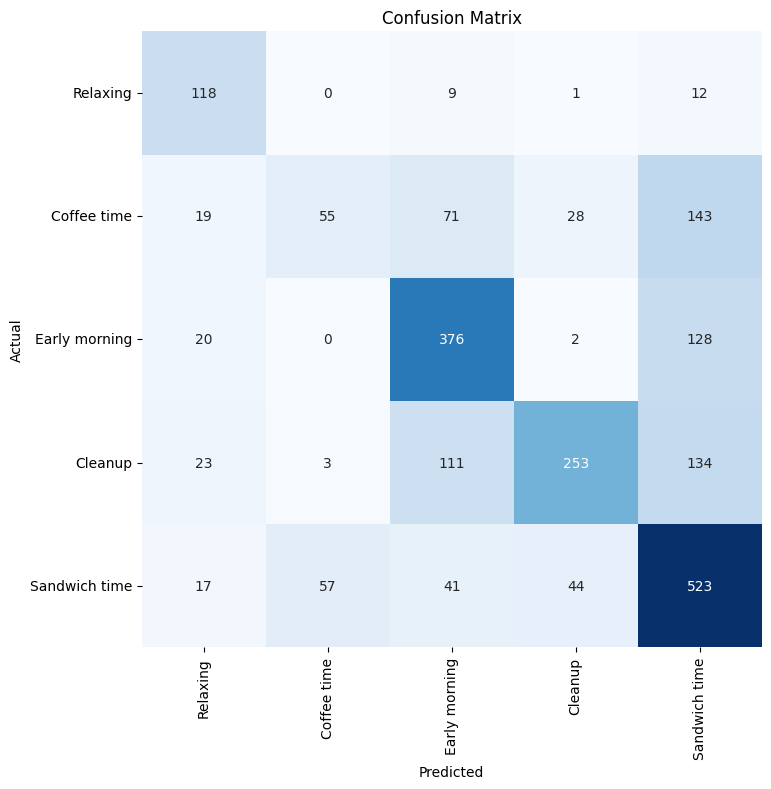


Number of model parameters is: 1122373
Epoch [1/5] | Batch [100/258] | Running Loss: 1.1475 | LR: 0.000089
Epoch [1/5] | Batch [200/258] | Running Loss: 0.7809 | LR: 0.000089
Epoch [2/5] | Batch [100/258] | Running Loss: 0.5796 | LR: 0.000089
Epoch [2/5] | Batch [200/258] | Running Loss: 0.4904 | LR: 0.000089
Epoch [3/5] | Batch [100/258] | Running Loss: 0.3783 | LR: 0.000089
Epoch [3/5] | Batch [200/258] | Running Loss: 0.3463 | LR: 0.000089
Epoch [4/5] | Batch [100/258] | Running Loss: 0.2832 | LR: 0.000089
Epoch [4/5] | Batch [200/258] | Running Loss: 0.2703 | LR: 0.000089
Epoch [5/5] | Batch [100/258] | Running Loss: 0.2036 | LR: 0.000089
Epoch [5/5] | Batch [200/258] | Running Loss: 0.2125 | LR: 0.000089

Finished Training.

Number of model parameters is: 1122373
Accuracy: 0.6271
Precision: 0.6696
Recall: 0.6271
F1 Score: 0.5913

Test accuracy of model: 62.71%


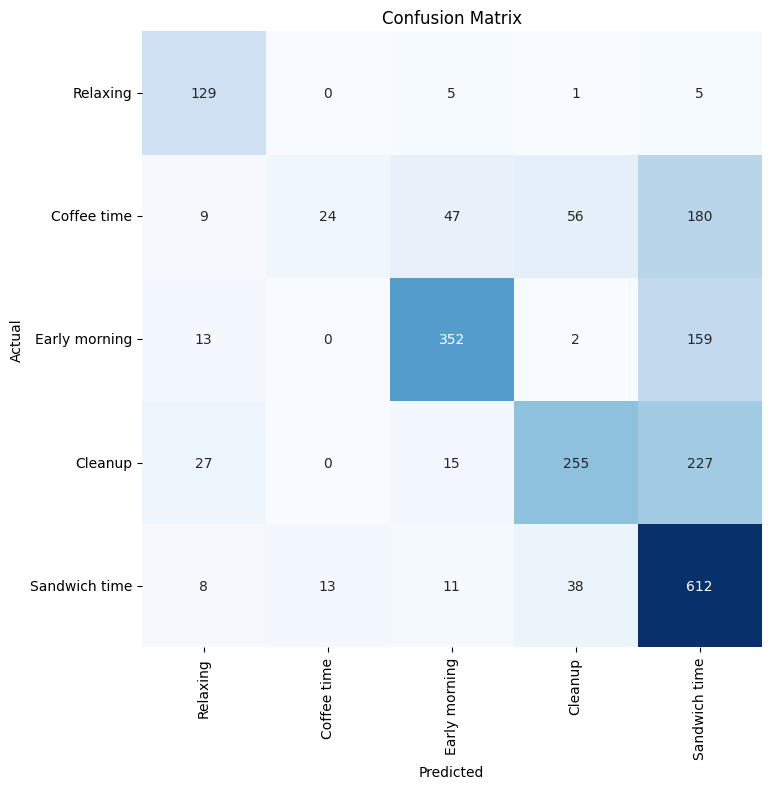


Number of model parameters is: 1122373
Epoch [1/5] | Batch [100/258] | Running Loss: 1.1476 | LR: 0.000089
Epoch [1/5] | Batch [200/258] | Running Loss: 0.7923 | LR: 0.000089
Epoch [2/5] | Batch [100/258] | Running Loss: 0.5686 | LR: 0.000089
Epoch [2/5] | Batch [200/258] | Running Loss: 0.4863 | LR: 0.000089
Epoch [3/5] | Batch [100/258] | Running Loss: 0.3857 | LR: 0.000089
Epoch [3/5] | Batch [200/258] | Running Loss: 0.3432 | LR: 0.000089
Epoch [4/5] | Batch [100/258] | Running Loss: 0.2983 | LR: 0.000089
Epoch [4/5] | Batch [200/258] | Running Loss: 0.2604 | LR: 0.000089
Epoch [5/5] | Batch [100/258] | Running Loss: 0.2138 | LR: 0.000089
Epoch [5/5] | Batch [200/258] | Running Loss: 0.2171 | LR: 0.000089

Finished Training.

Number of model parameters is: 1122373
Accuracy: 0.6193
Precision: 0.7101
Recall: 0.6193
F1 Score: 0.5785

Test accuracy of model: 61.93%


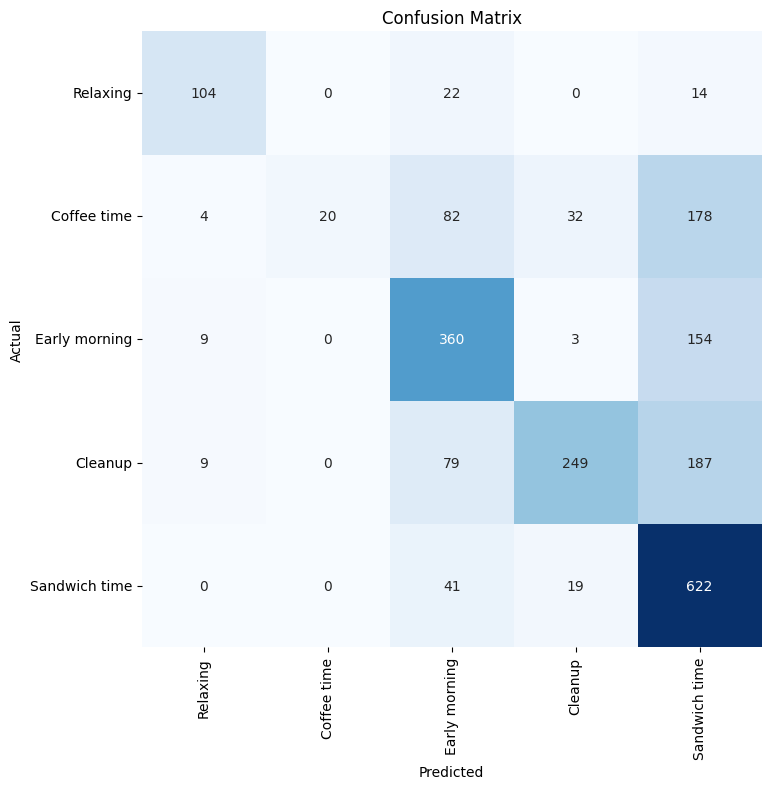

In [29]:
def set_seed(seed: int):
    """
    Sets the random seed for all relevant libraries to ensure
    reproducibility (or varied runs)
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    
    # These two are for ensuring cudnn determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

train_dataset = TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset
    , batch_size=batch_size,
    shuffle=True, num_workers=4)
seed_list = [310, 510, 734, 765, 503]
for i in range(len(seed_list)):
    set_seed(seed_list[i])
    model = CNNLSTM(
        input_size=input_size,
        cnn_channels=best_params['cnn_channels'],
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        output_size=output_size,
        dropout_rate=best_params['dropout_rate']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs, scheduler=scheduler)
    acc = test_model(model, test_loader=testloader)